# Profiling and Optimization Hands-On

In [1]:
import numpy as np
from math import sin, cos
import matplotlib.pyplot as plt
from time import sleep

%matplotlib inline

## A common problem: Which implementation is faster?

Example: Given a large 2D array, we will explore different ways to create the array and to calculate its mean. Determine which one is fastest, using the `%timeit` notebook function.

### setup: define our 2D array:

We'll make some dummy test data that looks like:

$M_{ij} = \sin(i)\cos(0.1 j)$

and we will construct this array in multiple ways.

In [2]:
def create_array_loop(N, M):
    """create a 2D array using a bare loop"""
    arr = []
    for y in range(M):
        row = []
        for x in range(N):
            row.append(sin(x) * cos(0.1 * y))
        arr.append(row)
    return arr


def create_array_list(N, M):
    """a 2D array using a list-comprehension"""
    return [[sin(x) * cos(0.1 * y) for x in range(N)] for y in range(M)]


def create_array_np(N, M):
    """ a 2D array using numpy"""
    X, Y = np.meshgrid(np.arange(N), np.arange(M))
    return np.sin(X) * np.cos(0.1 * Y)

Let's first just plot the arrays, to see if they are the same:

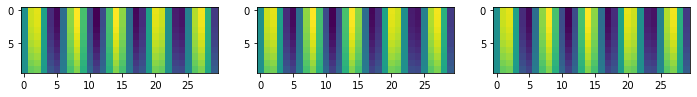

In [3]:
N = 30
M = 10  # our array dimensions
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(create_array_loop(N, M))
plt.subplot(1, 3, 2)
plt.imshow(create_array_list(N, M))
plt.subplot(1, 3, 3)
plt.imshow(create_array_np(N, M))

### Task: determine which array creation routine is fastest

And make a plot of the speed of each!   Does the result change much when the array size becomes larger? Try much larger sizes for N and M

Hint: use the `%timeit -o` magic function to have `%timeit` return results (see the timeit help)

### SOLUTION:

Note: to minimize the uncertainty, try increasing the problem size! 

In [4]:
N = 30
M = 10

**Useful tip**: timeit has a *-o* option that lets you save the results for later comparison!

In [5]:
t = {}  # a place to record out time statistics

In [6]:
t['loop'] = %timeit -o create_array_loop(N,M)

58.8 µs ± 71.5 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
t['list'] = %timeit -o create_array_list(N,M)

53 µs ± 157 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
t['numpy']  = %timeit -o create_array_np(N,M)

48.7 µs ± 1.34 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
def plot_performance(time_dict):
    mean = [t.average for t in time_dict.values()]
    std = [t.stdev for t in time_dict.values()]
    x = range(len(time_dict))
    plt.errorbar(x, mean, yerr=std, lw=3, fmt="o")
    plt.xticks(np.arange(len(time_dict)), time_dict.keys())
    plt.ylabel("average execution time (s)")
    plt.grid()

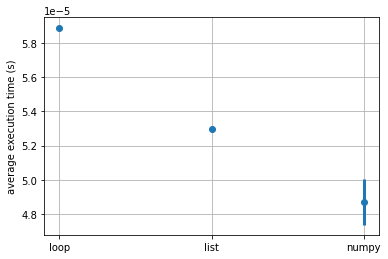

In [11]:
plot_performance(t)

## Task 2: determine the fastest way to find the mean of our array

note that `create_array_list()` and `create_array_loop` both return a list-of-lists, while `create_array_np` returns a 2D numpy array.   There are multiple ways to compute the mean of these arrays.  See again which is fastest!

try at least:

1. using the built-in python `sum` function and either a for-loop or list-comprehension
2. using pure numpy (e.g. `array.mean()`)
3. other ways you can think of!

### SOLUTION

In [12]:
N = 100
M = 100
a_list = create_array_list(N, M)
a_np = create_array_np(N, M)

In [13]:
sum([sum(x) for x in a_list]) / (N * M)

-0.00017124964340864182

In [14]:
a_np.mean()

-0.00017124964340864217

9.51 µs ± 32.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
11.3 µs ± 60.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
52.2 µs ± 66.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


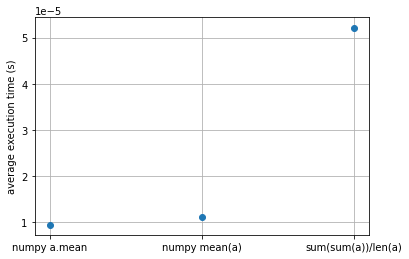

In [15]:
t2 = {}
t2["numpy a.mean"] = %timeit -o a_np.mean()
t2["numpy mean(a)"] = %timeit -o np.mean(a_np)
t2["sum(sum(a))/len(a)"] = %timeit -o sum([sum(x) for x in a_list])/(N*M)
plot_performance(t2)

# Using a profiler

A profiler gives you speed measurements of *all functions in your code at once* (and all their dependencies)

In [16]:
def slow_function(x):
    sleep(1)
    return x ** 2


def faster_function(x):
    return x ** 2

In [17]:
%%prun -r

for ii in range(5):
    x = slow_function(ii)
    y = faster_function(ii)

In [18]:
stats = _

In [19]:
stats.sort_stats("call").print_stats()

         18 function calls in 5.006 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        5    5.005    1.001    5.005    1.001 {built-in method time.sleep}
        5    0.000    0.000    5.005    1.001 2381721144.py:1(slow_function)
        5    0.000    0.000    0.000    0.000 2381721144.py:6(faster_function)
        1    0.000    0.000    5.006    5.006 {built-in method builtins.exec}
        1    0.000    0.000    5.005    5.005 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




## What about line profiling?

The syntax is: 
```
%lprun -f <function(s)>  <python statement that uses the function>
```

In [20]:
%load_ext line_profiler

In [21]:
def run_all():
    for ii in range(5):
        x = slow_function(ii)
        y = faster_function(ii)

In [22]:
%lprun -f run_all run_all() 

Try adding also `-f slow_function` to see inside that function as well!

In [23]:
%lprun -f create_array_loop create_array_loop(100,100)

In [25]:
%lprun -f run_all -f slow_function

## Using Snakevis to visualize a complex profile:

In [26]:
%%file some_long_script.py

import numpy as np
import time


def slow_function_1(x):
    time.sleep(3)
    return x


def frequently_called_function(x):
    time.sleep(0.001)
    return x


def slow_function_2(x):
    time.sleep(1)
    result = slow_function_1(x)
    for ii in range(10_000):
        result += frequently_called_function(x)
    return result


if __name__ == "__main__":

    print(slow_function_2(1))

Writing some_long_script.py


Run the profiler (you would do this in a terminal normally)

In [27]:
%%sh
python -mcProfile  -o some_long_script.pstats some_long_script.py

10001


Start the visualizer:

Run this in a terminal:
```sh
snakeviz some_long_script.pstats
```

### Try it  with a complex example: 
I included here as an example a long analysis of many simulated CTA gamma rays using the `ctapipe` software v0.14.x.  Some parts of this software are not yet optimized, and you can easily see which ones!

```sh
snakeviz ctapipe.pstats
```

# Memory Profiling

In [28]:
import numpy as np
from math import sin, cos

In [29]:
%load_ext memory_profiler

In [30]:
%memit np.sum(np.sin(np.arange(1000000)))

peak memory: 129.19 MiB, increment: 14.79 MiB


In [31]:
%memit sum(sin(x) for x in range(1000000))

peak memory: 114.80 MiB, increment: 0.00 MiB


One problem: in a notebook, this is measuring total memory, not just for the function being run, and is affected by garbage collection.  Try instead making modules:

In [32]:
%%writefile  tmp_sum.py

import numpy as np
import math


def do_some_sums(n=100_000):
    sum1 = np.sum(np.sin(np.arange(n)))
    sum2 = sum(math.sin(x) for x in range(n))
    make_big_array = np.zeros(1_000_000) * 0.5
    return sum1 + sum2

Writing tmp_sum.py


In [33]:
from tmp_sum import do_some_sums

In [34]:
%mprun -f do_some_sums do_some_sums(500_000)